In [1]:
!pip install torch_geometric -q

In [1]:
import pickle
with open('merged_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
loaded_data[0]

[[1, 3, 0, 7, 2, 9],
 [array([ 72,  94, 125,  34], dtype=int64),
  array([ 72, 125, 108,  97], dtype=int64),
  array([111, 227, 185,  51], dtype=int64),
  array([ 72, 168, 125, 128], dtype=int64),
  array([115, 202, 145, 171], dtype=int64),
  array([128,  48, 185,  26], dtype=int64)],
 [5, 5, 1, 7, 0, 4],
 [7, 1, 6, 7, 2, 2]]

In [2]:
# i=0
# for sublist in loaded_data_1:
#     loaded_data[i].append(sublist[3][:-1])
#     i+=1
#     if i==80788:
#         break

In [3]:
from collections import defaultdict, Counter
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import torch
import numpy as np
import pickle


class FloorplanGraphDataset(Dataset):
    def __init__(self, path, split=None):
        super(FloorplanGraphDataset, self).__init__()
        self.path = path
        with open(self.path, 'rb') as f:
            loaded_data = pickle.load(f)
        self.subgraphs = loaded_data
        self.subgraphs = self.filter_graphs(self.subgraphs)
        if split=='train':
            self.subgraphs = self.subgraphs[:120000]
        elif split=='test':
            self.subgraphs = self.subgraphs[120000:]    
        num_nodes = defaultdict(int)
        for g in self.subgraphs:
            labels = g[0] 
            if len(labels) > 0:
                num_nodes[len(labels)] += 1
        print(f'Number of graphs: {len(self.subgraphs)}')
        print(f'Number of graphs by rooms: {num_nodes}')
        
    def len(self):
        return len(self.subgraphs)

    def get(self, index, bbs=False):
        graph = self.subgraphs[index]
        labels = np.array(graph[0])
        vastu=np.array(graph[3])
        rooms_bbs = np.array(graph[1])
        orientation=graph[2]
        temp=rooms_bbs
#         edge2node = [item for sublist in graph[3] for item in sublist]
#         node_doors = np.array(edge2node)[graph[4]]
#         doors_count = Counter(node_doors)
        features = []
        rooms_bbs_new = []
        for i, bb in enumerate(rooms_bbs):
            x0, y0 = bb[0], bb[1]
            x1, y1 = bb[2], bb[3]
            #temp.append([x0,y0,x1,y1])
            xmin, ymin = min(x0, x1), min(y0, y1)
            xmax, ymax = max(x0, x1), max(y0, y1)
            l, b = xmax - xmin, ymax - ymin
            area = l*b
            if l<b:
                l, b = b, l
            features.append([area, l, b, 0, 0,orientation[i]]) 
            rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
        rooms_bbs = np.stack(rooms_bbs_new)
        intersect = self.intersect(rooms_bbs,rooms_bbs)
        for i in range(len(rooms_bbs)):
            for j in range(i+1,len(rooms_bbs)):
                if intersect[i,j]>0.7*intersect[j,j]:
                    if intersect[i,i]>intersect[j,j]: #is i a parent
                        features[i][4] = 1
                        features[j][3] = 1
                    else:   # i is child
                        features[i][3] = 1
                        features[j][4] = 1
                if intersect[i,j]>0.7*intersect[i,i]:
                    if intersect[j,j]>intersect[i,i]: 
                        features[j][4] = 1
                        features[i][3] = 1
                    else:
                        features[j][3] = 1
                        features[i][4] = 1

        rooms_bbs = rooms_bbs/256.0

        tl = np.min(rooms_bbs[:, :2], 0)
        br = np.max(rooms_bbs[:, 2:], 0)
        shift = (tl+br)/2.0 - 0.5
        rooms_bbs[:, :2] -= shift
        rooms_bbs[:, 2:] -= shift
        tl -= shift
        br -= shift
        edges = self.build_graph(rooms_bbs,temp) 
#         labels = labels - 1
#         labels[labels>=5] = labels[labels>=5] - 1
        x = torch.tensor(features, dtype=torch.float)
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        y1 = torch.tensor(labels, dtype=torch.long) #y
        y2 = torch.tensor(vastu, dtype=torch.long) ##
        d = Data(x=x, edge_index=edge_index, y_1=y1, y_2=y2) #y=y
        if bbs:
            return d, rooms_bbs
        return d

    def build_graph(self, bbs,temp):
        edges = []
        for k in range(len(bbs)):
            for l in range(len(bbs)):
                if l > k:
                    bb0 = bbs[k]
                    bb1 = bbs[l]
                    #print(bbs,temp)
                    bb2 = temp[k]
                    bb3 = temp[l]
                    if self.is_adjacent(bb0, bb1) and  self.manhattam(bb2,bb3):
                        edges.append([k, l])
                        edges.append([l, k])
        edges = np.array(edges)
        return edges

    def filter_graphs(self, graphs):
        new_graphs = []
        for g in graphs:       
            labels = g[0]
            rooms_bbs = g[1]
            # discard broken samples
            check_none = np.sum([bb is None for bb in rooms_bbs])
            #check_node = np.sum([nd == 0 for nd in labels])
            if (len(labels) < 2) or (check_none > 0):
                continue
            new_graphs.append(g)
        return new_graphs

    def is_adjacent(self, box_a, box_b, threshold=0.03):
        
        x0, y0, x1, y1 = box_a
        x2, y2, x3, y3 = box_b

        h1, h2 = x1-x0, x3-x2
        w1, w2 = y1-y0, y3-y2

        xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
        yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0

        delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
        delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0

        delta = max(delta_x, delta_y)

        return delta < threshold

    def intersect(self, A,B):
        A, B = A[:,None], B[None]
        low = np.s_[...,:2]
        high = np.s_[...,2:]
        A,B = A.copy(),B.copy()
        A[high] += 1; B[high] += 1
        intrs = (np.maximum(0,np.minimum(A[high],B[high])
                            -np.maximum(A[low],B[low]))).prod(-1)
        return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)
    def manhattam(self,box_a, box_b):
        x0, y0, x1, y1 = box_a
        x2, y2, x3, y3 = box_b

        if x2>=x1 and y2<=y1:
            return False
        elif x2>=x1 and y3>=y0:
            return False
        elif x3<=x0 and y3>=y0:
            return False
        elif x3<=x0 and y2<=y1:
            return False
        else:
            return True

In [4]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master oom",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}
# def visualize(d, bbs=None):
#     G = to_networkx(d, to_undirected=True)
#     plt.figure(figsize=(7,7))
#     plt.axis('off')
#     labels = {i: MOD_ROOM_CLASS[int(d.y[i])] for i in range(len(d.y))}
#     c = plt.get_cmap('tab20').colors
#     color = [c[i] for i in d.y]
#     nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, labels=labels, node_color=color, cmap='Dark2')
#     plt.show()
#     if bbs is not None:
#         plt.figure(figsize=(7,7))
#         for i, (xmin, ymin, xmax, ymax) in enumerate(bbs):
#             rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='k', facecolor=c[d.y[i]], alpha=0.9)
#             plt.gca().add_patch(rect)
#         plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
#from dataset import MOD_ROOM_CLASS

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# def accuracy(model, dataloader):
#     correct = 0
#     num_nodes = 0
#     model.to(device)
#     model.eval()
#     for data in dataloader:
#         data = data.to(device)
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(1)
#         correct += sum(pred==data.y)
#         num_nodes += data.num_nodes
#     return (correct/num_nodes).item()
def accuracy(model, dataloader):
    correct = 0
    vastu_correct = 0
    num_nodes = 0
    model.to(device)
    model.eval()
    for data in dataloader:
        data = data.to(device)
        out, vastu_out = model(data.x, data.edge_index)
        pred = out.argmax(1)
        vastu_pred = vastu_out.argmax(1)
        correct += sum(pred == data.y_1)
        vastu_correct += sum(vastu_pred == data.y_2)
        num_nodes += data.num_nodes
    return (correct / num_nodes).item(), (vastu_correct / num_nodes).item()

In [6]:
device

device(type='cpu')

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(6, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier1 = Linear(16, 13) #self.classifier
        self.classifier2 = Linear(16, 8)##

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out_1 = self.classifier1(h) #out
        out_2 = self.classifier2(h) ##
        return out_1,out_2 #out

In [8]:
import torch
import numpy as np
#from dataset import FloorplanGraphDataset
#from utils import  accuracy
#from model import Model
from torch.nn import Linear
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv
import pathlib
#import argparse

model_type = 'sage'  # 'mlp', 'gcn', 'gat', 'sage', 'tagcn'
hidden_layers = 6
num_epochs = 100
learning_rate = 0.004
step_size = 10
gamma = 0.8
batch_size = 128
outpath = 'results'
dataset_file = 'merged_data.pkl'
models = {
    'mlp': Linear,
    'gcn': GCNConv,
    'gat': GATConv,
    'sage': SAGEConv,
    'tagcn': TAGConv,
}
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

outpath = pathlib.Path(outpath) #
outpath.mkdir(parents=True, exist_ok=True) #

torch.manual_seed(42) #
model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
print(model)
model = model.to(device)

cpu
Model(
  (layer1): SAGEConv(6, 16, aggr=mean)
  (layer2): ModuleList(
    (0-4): 5 x SAGEConv(16, 16, aggr=mean)
  )
  (classifier1): Linear(in_features=16, out_features=13, bias=True)
  (classifier2): Linear(in_features=16, out_features=8, bias=True)
)


In [9]:
dataset = FloorplanGraphDataset(path=dataset_file, split=None)
train = [dataset[i].to(device) for i in range(65000)]
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
trainloader2 = DataLoader(train, batch_size=65000)
test = [dataset[i].to(device) for i in range(65000,80788)]
testloader = DataLoader(test, batch_size=15788)

Number of graphs: 80788
Number of graphs by rooms: defaultdict(<class 'int'>, {6: 25104, 7: 29278, 8: 20364, 5: 5788, 4: 254})


e:\Anaconda\envs\graph\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
dataset.get(2).x

tensor([[1.0260e+03, 3.8000e+01, 2.7000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.7050e+03, 5.5000e+01, 3.1000e+01, 0.0000e+00, 0.0000e+00, 7.0000e+00],
        [2.4840e+03, 5.4000e+01, 4.6000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00],
        [3.0080e+03, 6.4000e+01, 4.7000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00],
        [2.7730e+03, 5.9000e+01, 4.7000e+01, 0.0000e+00, 0.0000e+00, 6.0000e+00],
        [9.5900e+03, 1.3700e+02, 7.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.7200e+02, 5.4000e+01, 1.8000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00]])

In [11]:
dataset.get(2).y_2 #y_1

tensor([0, 6, 2, 7, 2, 7, 2])

In [126]:
num_epochs = num_epochs
lr = learning_rate
step_size = step_size
gamma = gamma
outpath = '/kaggle/working/'

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_ep = []
tr_acc_ep = []
te_acc_ep = []
tr_vastu_acc_ep=[]
te_vastu_acc_ep = []

In [127]:
for epoch in range(num_epochs):
    model.train()
    loss = 0
    for data in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        out, vastu_out = model(data.x, data.edge_index)
        loss_cls = criterion(out, data.y_1)
        loss_vastu = criterion(vastu_out, data.y_2)
        loss_ = loss_cls + loss_vastu
        loss_.backward()
        optimizer.step()
        loss += loss_.item()
    exp_lr_scheduler.step()
    loss /= len(train)
    tr_acc, tr_vastu_acc = accuracy(model, trainloader2)
    te_acc, te_vastu_acc = accuracy(model, testloader)
    loss_ep.append(loss)
    tr_acc_ep.append(tr_acc)
    te_acc_ep.append(te_acc)
    tr_vastu_acc_ep.append(tr_vastu_acc)
    te_vastu_acc_ep.append(te_vastu_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.10f}, Train Acc: {tr_acc:.6f}, Train Vastu Acc: {tr_vastu_acc:.6f}, Test Acc: {te_acc:.6f}, Test Vastu Acc: {te_vastu_acc:.6f}')

Epoch [1/100] Loss: 0.0256703727, Train Acc: 0.735481, Train Vastu Acc: 0.260983, Test Acc: 0.723197, Test Vastu Acc: 0.235799
Epoch [2/100] Loss: 0.0207266459, Train Acc: 0.750866, Train Vastu Acc: 0.268526, Test Acc: 0.736433, Test Vastu Acc: 0.243812
Epoch [3/100] Loss: 0.0202772434, Train Acc: 0.754916, Train Vastu Acc: 0.284855, Test Acc: 0.740002, Test Vastu Acc: 0.255874
Epoch [4/100] Loss: 0.0199887407, Train Acc: 0.774819, Train Vastu Acc: 0.291791, Test Acc: 0.757879, Test Vastu Acc: 0.260514
Epoch [5/100] Loss: 0.0197585157, Train Acc: 0.774414, Train Vastu Acc: 0.296878, Test Acc: 0.758452, Test Vastu Acc: 0.268264
Epoch [6/100] Loss: 0.0195275879, Train Acc: 0.788365, Train Vastu Acc: 0.298115, Test Acc: 0.771547, Test Vastu Acc: 0.267513
Epoch [7/100] Loss: 0.0193027268, Train Acc: 0.790087, Train Vastu Acc: 0.307697, Test Acc: 0.776244, Test Vastu Acc: 0.275432
Epoch [8/100] Loss: 0.0189995269, Train Acc: 0.811472, Train Vastu Acc: 0.318003, Test Acc: 0.796545, Test Vast

In [128]:
result = np.array([loss_ep, tr_acc_ep, te_acc_ep, te_vastu_acc_ep]).T

In [129]:
np.savetxt(outpath+f'{type(model.layer1).__name__}{len(model.layer2)+1}_loss_tracc_teacc_tevastu_{lr}_{num_epochs}_{step_size}_{gamma}.txt', result)

In [130]:
max_idx = result[:,2].argmax()  # For regular target label
max_vastu_idx = result[:,3].argmax()  # For vastu_y target label

print(f'\nMax Test Accuracy at Epoch {max_idx+1}: {result[max_idx]}\nMax Vastu Test Accuracy at Epoch {max_vastu_idx+1}: {result[max_vastu_idx]}')


Max Test Accuracy at Epoch 100: [0.0069962  0.83832103 0.81878984 0.84848428]
Max Vastu Test Accuracy at Epoch 94: [0.006912   0.83823955 0.81815106 0.84920764]


In [13]:
# Save the trained model
# torch.save(model.state_dict(), 'SAGE_merged_trained_model_layers6.pth')

In [12]:
# Load the saved model
loaded_model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
loaded_model.load_state_dict(torch.load('SAGE_merged_trained_model_layers6.pth',map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): SAGEConv(6, 16, aggr=mean)
  (layer2): ModuleList(
    (0-4): 5 x SAGEConv(16, 16, aggr=mean)
  )
  (classifier1): Linear(in_features=16, out_features=13, bias=True)
  (classifier2): Linear(in_features=16, out_features=8, bias=True)
)

In [13]:
new_features=dataset.get(80000)

In [14]:
with torch.no_grad():
    x, edge_index = new_features.x, new_features.edge_index
    new_predictions, new_vastu_predictions = loaded_model(x, edge_index)

In [15]:
new_predictions

tensor([[ 4.4115e+00,  7.3027e+00,  1.7861e+01,  1.4534e+01,  1.2211e+01,
          1.1669e+01,  1.3754e+01,  1.2433e+01,  1.0230e+01,  1.4267e+01,
          1.0245e+01,  9.6671e+00,  8.8534e+00],
        [ 2.7591e+01,  1.8222e+01,  1.4741e+01, -1.3651e+02,  1.8374e+01,
          1.1369e+01,  1.3150e+01,  1.2516e+01,  7.4637e+00,  1.5405e+01,
         -7.7417e+01, -8.3035e+01, -9.3078e+01],
        [ 1.0499e+01,  1.4749e+01,  1.4456e+01,  1.5528e+01,  1.2992e+01,
          1.6445e+01,  1.7703e+01,  1.9469e+01,  1.4624e+01,  1.5417e+01,
          1.1291e+01,  1.1546e+01,  1.2633e+01],
        [-1.0995e+00, -6.4392e+00,  5.3175e+00,  1.0121e+01,  8.1297e-01,
         -5.8888e-01,  2.1137e+00, -5.0995e-02, -2.1141e+00,  1.9181e+00,
         -7.8679e-02,  4.0537e+00,  4.4513e+00],
        [ 7.1044e+00,  1.5414e+01,  5.2126e+00,  1.9500e+00,  6.1611e+00,
          7.6732e+00,  7.1100e+00,  1.1778e+01,  6.5078e+00,  6.9868e+00,
          2.5236e+00,  5.3505e-02, -3.1825e-01],
        [ 2.545

In [16]:
new_vastu_predictions

tensor([[-1.9311e-01, -2.2797e+01,  1.5879e+00, -1.3484e+00,  3.0444e+00,
         -2.2873e+00,  7.6885e+00,  5.1187e+00],
        [ 1.0583e+01, -1.6812e+01, -3.8271e+01,  1.5693e+01,  1.7829e+01,
          2.4961e+01,  1.9329e+01, -9.8983e+00],
        [ 1.9571e+00, -1.9584e+01, -3.5903e+00,  3.8032e-02,  4.6128e-01,
         -4.4205e+00,  5.6219e+00,  9.2828e+00],
        [-7.5224e-01, -2.2043e+00, -3.4610e+00,  4.8092e+00, -2.4565e-01,
          1.3578e+00, -7.5849e+00, -8.5665e-01],
        [ 2.4479e+00,  4.7271e+00, -2.6235e+00, -5.1417e+00, -8.4897e+00,
          1.1270e+00, -1.5011e+00,  8.1861e+00],
        [ 3.0715e+00, -1.2222e+01, -3.1867e+00, -7.1563e-01, -4.8554e+00,
          4.3176e+00, -2.7060e-01, -5.2259e+00],
        [-7.0655e+00,  1.8906e+00,  8.4317e+00,  3.6056e+00, -7.4091e+00,
          2.0793e+00,  9.2515e-01, -7.3647e+00]])

In [17]:
# For regular target label
predicted_categories = new_predictions.argmax(dim=1)
predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in predicted_categories]
predicted_room_categories

['Kitchen',
 'Living room',
 'Second room',
 'Bathroom',
 'Master oom',
 'Second room',
 'Balcony']

In [18]:
new_features.y_1

tensor([2, 0, 7, 3, 1, 6, 9])

In [19]:
predicted_vastu_categories = new_vastu_predictions.argmax(dim=1)
predicted_vastu_categories

tensor([6, 5, 7, 3, 7, 5, 2])

In [20]:
new_features.y_2

tensor([6, 5, 7, 3, 7, 5, 2])

#Over

In [21]:
def visualize(data_list, num_rows=2, num_cols=3):
    num_samples = len(data_list)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols*2, figsize=(30, 15))  # Increase figure size
    axs = axs.flatten()

    for i, (d, ax1, ax2) in enumerate(zip(data_list, axs[::2], axs[1::2])):
        if i >= num_rows * num_cols:
            break

        G = to_networkx(d, to_undirected=True)
        labels = {j: MOD_ROOM_CLASS[int(d.y[j])] for j in range(len(d.y))}
        c = plt.get_cmap('tab20').colors
        color = [c[j] for j in d.y]

        pos = nx.spring_layout(G, seed=42, k=0.15)  # Adjust the spring layout parameter

        # Ground truth
        nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=color, cmap='Dark2', ax=ax1, node_size=500,font_weight='bold')  # Increase node size
        ax1.set_title(f"Test Graph Ground Truth {i}", fontsize=20)  # Increase title font size
        ax1.set_axis_off()

        # Prediction
        pred_labels = {j: MOD_ROOM_CLASS[int(d.y_pred[j])] for j in range(len(d.y_pred))}
        nx.draw_networkx(G, pos=pos, with_labels=True, labels=pred_labels, node_color=[c[j] for j in d.y_pred], cmap='Dark2', ax=ax2, node_size=500,font_weight='bold')
        ax2.set_title(f"Test Graph Prediction {i}", fontsize=20)
        ax2.set_axis_off()

    plt.tight_layout()
    plt.show()

e:\Anaconda\envs\graph\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


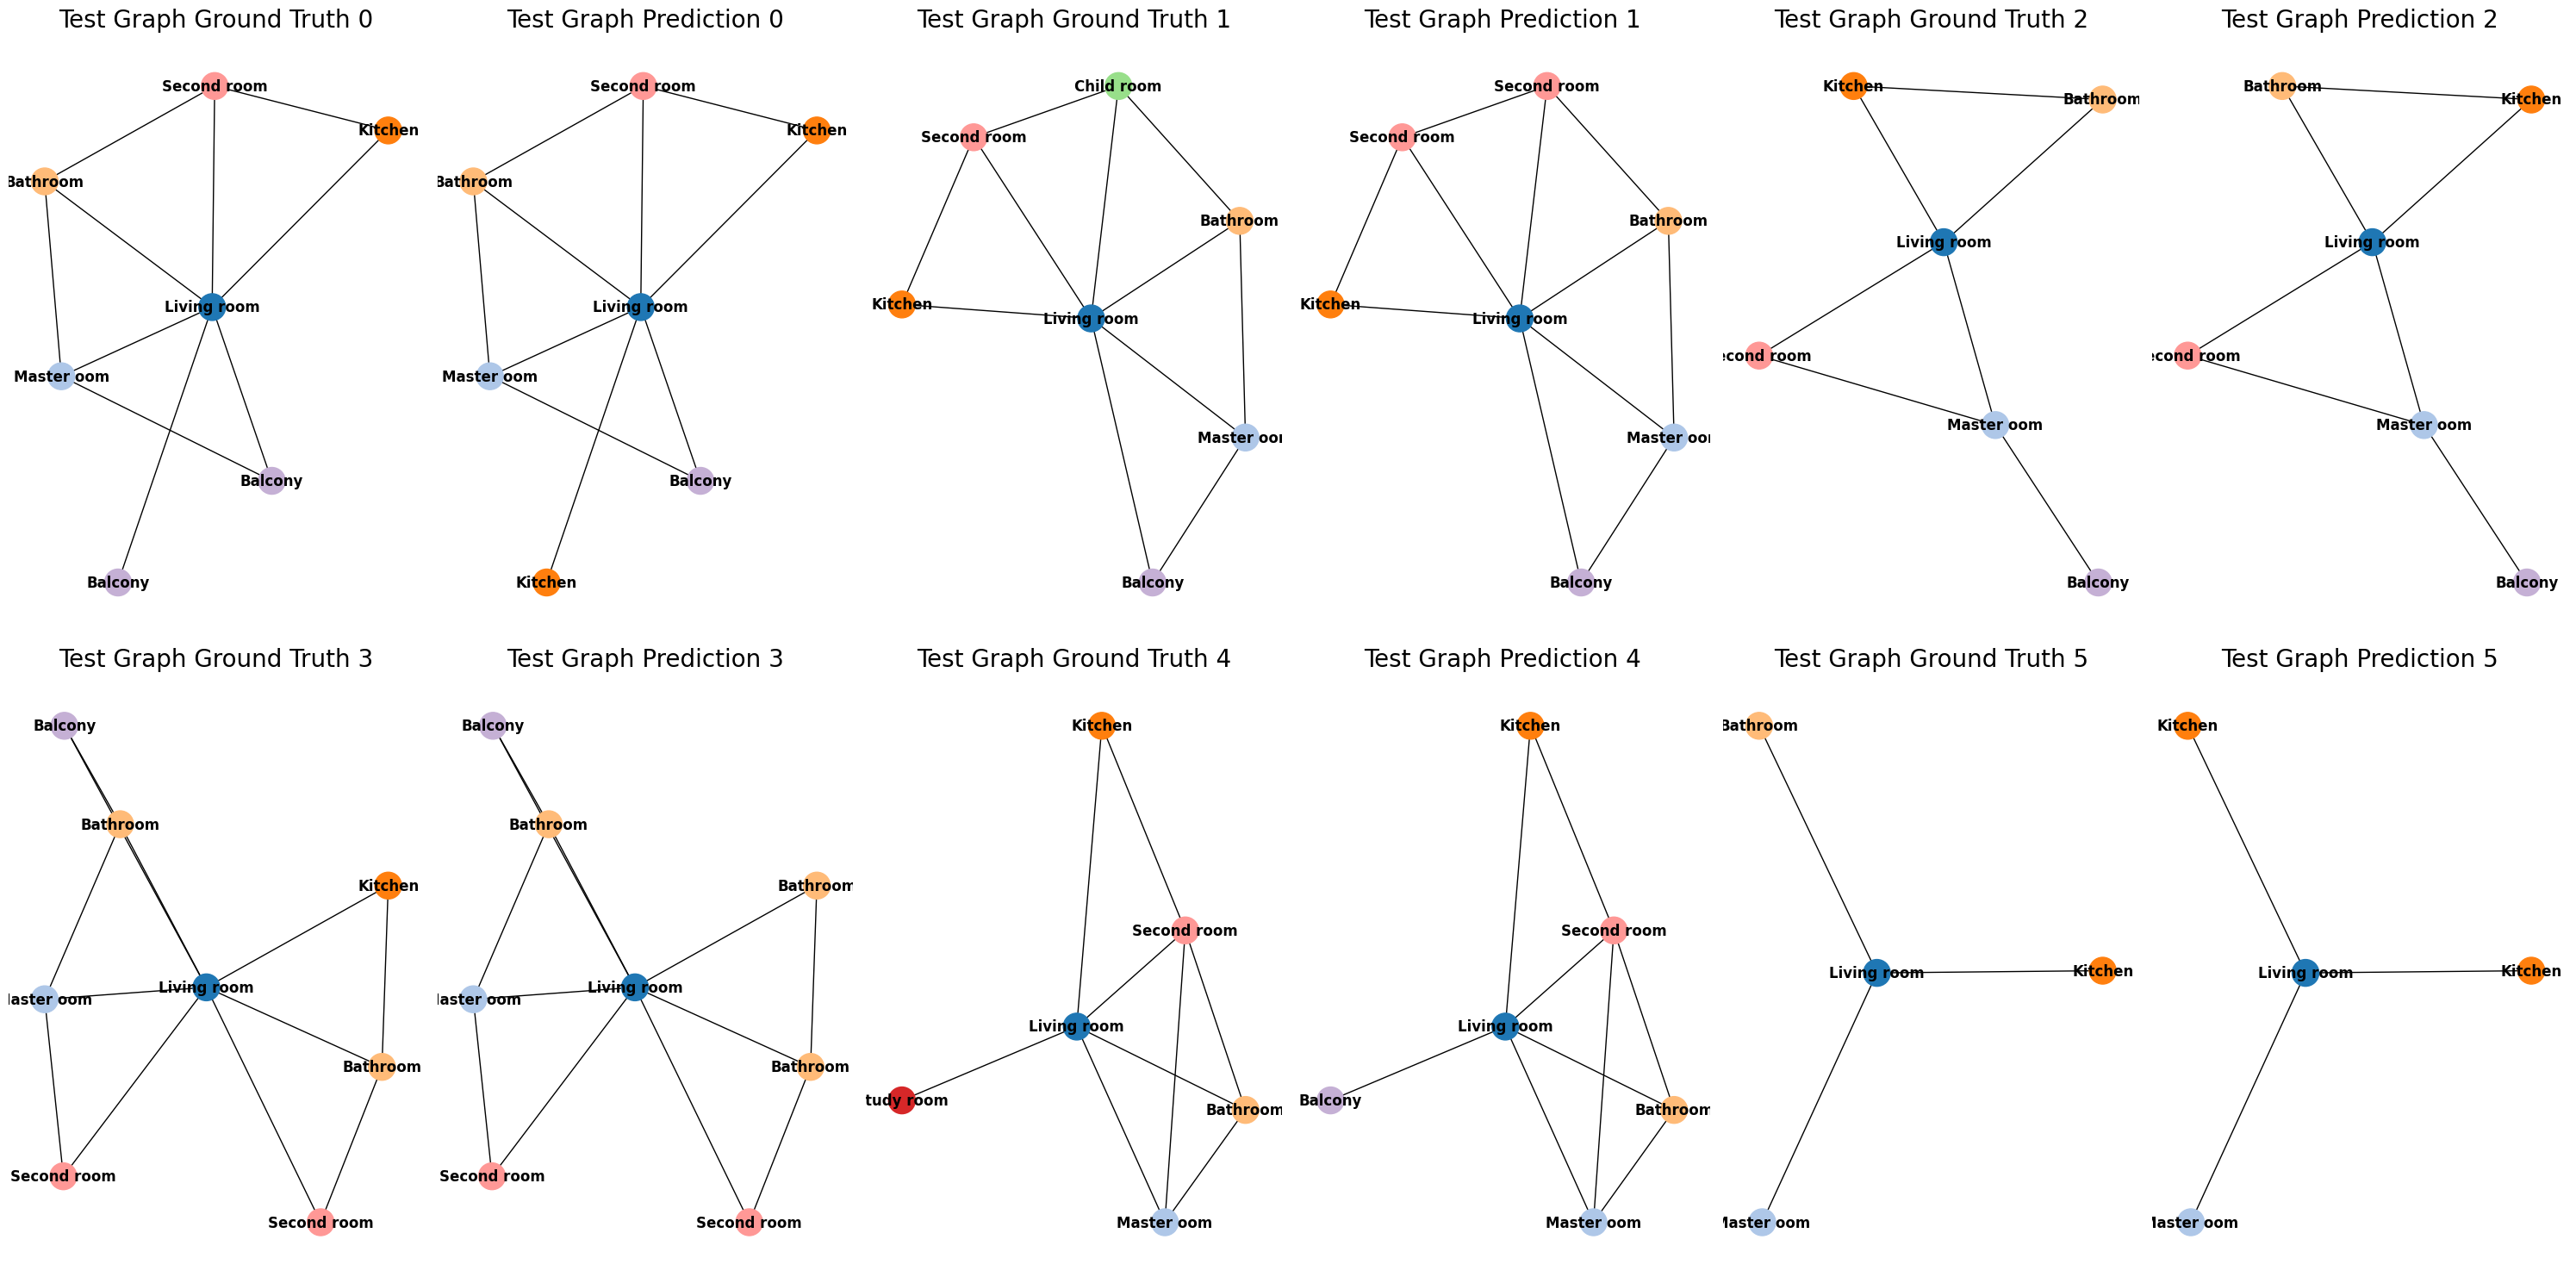

In [22]:
from torch_geometric.data import Data

# Assuming you have your trained model
#model = ...

# Create a list to store the Data objects
data_list = []
#check=[]
check=[65002,
 65003,
 65004,
 65005,
 65006,
 65007,65009]
#  65009,
#  65010,
#  65011,
#  65012]
# # Iterate over your test dataset
for i in check:
    data = dataset.get(i)
    
    # Make predictions
    with torch.no_grad():
        pred,_ = loaded_model(data.x, data.edge_index)
        pred=pred.argmax(dim=1)
        #print(pred)
    
    # Create a new Data object with the predictions
    
    # if not torch.eq(data.y_1, pred).all():
    #     #print(data.y_1, pred)
    #     #print(i)
    #     check.append(i)
    new_data = Data(x=data.x, edge_index=data.edge_index, y=data.y_1, y_pred=pred)
    data_list.append(new_data)

# Visualize the test results
visualize(data_list)

In [69]:
check

[65002,
 65003,
 65004,
 65005,
 65006,
 65007,
 65009,
 65010,
 65011,
 65012,
 65013,
 65014,
 65017,
 65018,
 65019,
 65020,
 65024,
 65026,
 65027,
 65030,
 65031,
 65032,
 65036,
 65037,
 65039,
 65041,
 65044,
 65045,
 65046,
 65047,
 65048,
 65049]